In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
offers = pd.read_csv('offerings.csv')

In [6]:
promotionMapper =  {
    'noOffer':0,
    'bronze':1,
    'silver':2,
    'gold':3
}
offers['promotion_type'] = offers['promotion_type'].map(promotionMapper)

In [7]:
educationMapper = {
    'no_hs_diploma':0,
    'grad_high_school':1,
    'some_college':2,
    'grad_college':3,
    'masters_professional':4,
    'phd':5
}
offers['education_level'] = offers['education_level'].map(educationMapper)

In [8]:
target_cols = ['promotion_type','conversion_ind','ltv']
targetFrame = offers[target_cols].copy()
offers = offers.drop(target_cols,axis=1)
num_cols = offers.select_dtypes(np.number).columns
cat_cols = ['residence_type','job_type','primary_credit_card','cable_provider']


# EDA

In [6]:
targetFrame.conversion_ind.value_counts()

1.0    5040
0.0    4961
Name: conversion_ind, dtype: int64

In [7]:
targetFrame.promotion_type.value_counts()

1    3457
2    3328
3    3216
Name: promotion_type, dtype: int64

<AxesSubplot: xlabel='ltv', ylabel='Density'>

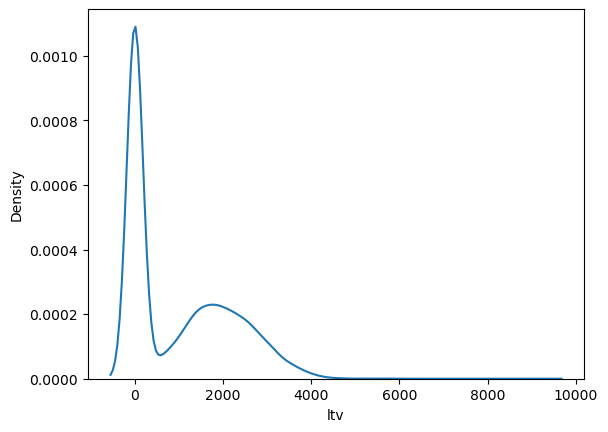

In [8]:
sns.kdeplot(targetFrame.ltv)

## data preprocess

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

In [11]:
ohe.fit(offers[cat_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [39]:
simpleX = offers[num_cols].join(
    offers[cat_cols]
)

# data split

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
RANDOM_SEED = 1337

In [43]:
xTrain, xTest, yTrain, yTest = train_test_split(simpleX,targetFrame,test_size=0.2,random_state=RANDOM_SEED)

In [56]:
xTrainEnc = xTrain.drop(cat_cols,axis=1).join(
    pd.DataFrame(ohe.fit_transform(xTrain[cat_cols]),columns=ohe.get_feature_names_out())
)
xTestEnc = xTest.drop(cat_cols,axis=1).join(
    pd.DataFrame(ohe.transform(xTest[cat_cols]),columns=ohe.get_feature_names_out())
)

# conversion model

In [58]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [59]:
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay

## Logistic

In [69]:
logReg = LogisticRegression(penalty='l2',class_weight='balanced',max_iter=1000)

In [70]:
logReg.fit(
    xTrainEnc.join(yTrain['promotion_type']).fillna(0),
    yTrain['conversion_ind']
)

c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [95]:
log_preds = logReg.predict_proba(xTestEnc.join(yTest['promotion_type']).fillna(0))

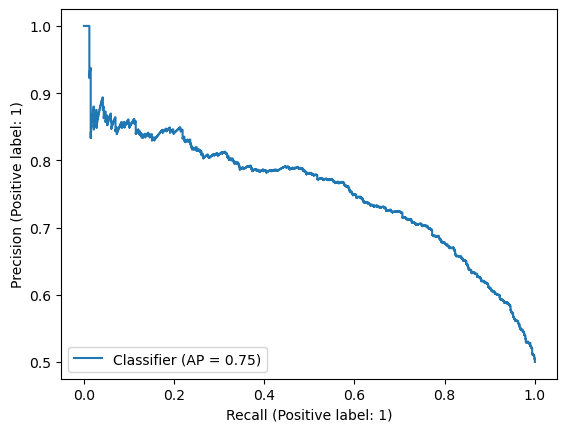

In [96]:
PrecisionRecallDisplay.from_predictions(yTest['conversion_ind'],log_preds[:,1])

In [98]:
confusion_matrix(yTest['conversion_ind'],log_preds.argmax(axis=1))

array([[689, 311],
       [258, 743]], dtype=int64)

## XGB

In [61]:
prop = yTrain.conversion_ind.value_counts()
scale_weight = prop.loc[0]/prop.loc[1]

In [62]:
xgbClf = XGBClassifier(
    gamma=0,
    objective= 'binary:logistic',
    importance_type='gain',
    nthread=4,
    seed=RANDOM_SEED,
    scale_pos_weight=scale_weight
)

In [63]:
xgb_grid_cv = GridSearchCV(
    xgbClf,
    param_grid={
        'learning_rate':[0.1,0.3],
        'n_estimators':[10,20,30],
        'min_child_weight':[1,2],
        'max_depth':[5,6,7],
        'colsample_bytree':[0.9,1],
        'colsample_bylevel':[0.9,1]
    },
    scoring='average_precision',cv=5)
xgb_grid_cv.fit(xTrainEnc.join(yTrain['promotion_type']),yTrain['conversion_ind'])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'colsample_bylevel': [0.9, 1],
                         'colsample_bytree': [0.9, 1],
                         'learning_rate': [0.1, 0.3], 'max_depth': [5, 6, 7],
                         'min_child_weight': [1, 2],
                         'n_estimators': [10, 20, 30]},
             scoring='average_precision')

In [64]:
pd.DataFrame(xgb_grid_cv.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.121611,0.005463,0.005189,0.000387,0.9,0.9,0.1,5,1,30,"{'colsample_bylevel': 0.9, 'colsample_bytree':...",0.887277,0.901072,0.916395,0.897806,0.902943,0.901098,0.009373,1
5,0.124415,0.010565,0.004785,0.000393,0.9,0.9,0.1,5,2,30,"{'colsample_bylevel': 0.9, 'colsample_bytree':...",0.887186,0.900734,0.916682,0.897043,0.902334,0.900796,0.009529,2
38,0.136804,0.011707,0.005796,0.000402,0.9,1,0.1,5,1,30,"{'colsample_bylevel': 0.9, 'colsample_bytree':...",0.886938,0.900952,0.915454,0.896028,0.903911,0.900657,0.009373,3


In [83]:
xgb_preds = xgb_grid_cv.predict_proba(xTestEnc.join(yTest['promotion_type']))

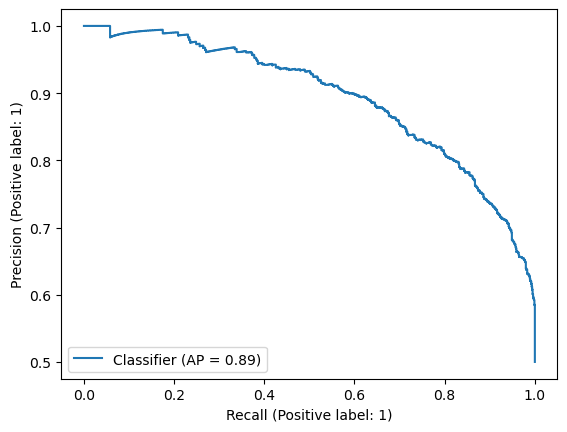

In [84]:
PrecisionRecallDisplay.from_predictions(
    yTest['conversion_ind'],
    xgb_preds[:,1]
)

In [94]:
confusion_matrix(yTest['conversion_ind'],xgb_preds.argmax(axis=1))

array([[800, 200],
       [187, 814]], dtype=int64)

In [33]:
convImps = pd.Series(
    xgb_grid_cv.best_estimator_.feature_importances_,
        index=xTrain.join(yTrain['promotion_type']).columns
).sort_values(ascending=False)
convImps.head(5)

primary_credit_card_nan      0.349118
prior_year_spend_external    0.202368
promotion_type               0.166920
last_ticket_purchase_year    0.049850
age                          0.023291
dtype: float32

## Catboost

In [36]:
from catboost import CatBoostClassifier

In [ ]:
cbc = CatBoostClassifier(
        learning_rate=0.1,
        loss_function='Logloss',
        verbose=False
    )

In [ ]:
xgb_grid_cv = GridSearchCV(
    xgbClf,
    param_grid={
        'learning_rate':[0.1,0.3],
        'n_estimators':[10,20,30],
        'min_child_weight':[1,2],
        'max_depth':[5,6,7],
        'colsample_bytree':[0.9,1],
        'colsample_bylevel':[0.9,1]
    },
    scoring='average_precision',cv=5)
xgb_grid_cv.fit(xTrainEnc.join(yTrain['promotion_type']),yTrain['conversion_ind'])

# promotion model

## XGB

## Catboost

# ltv model

## XGB

In [19]:
xgbReg = XGBRegressor(
    gamma=0,
    objective='reg:squarederror',
    nthread=4,
    seed=RANDOM_SEED
)

In [20]:
reg_xgb_grid_cv = GridSearchCV(
    xgbReg,
    param_grid={
        'learning_rate':[0.2],
        'n_estimators':[10,15],
        'min_child_weight':[1,2],
        'max_depth':[5,6,7],
        'colsample_bytree':[0.9,1],
        'colsample_bylevel':[0.9,1]
    },
    scoring='neg_mean_squared_error',cv=5)

In [21]:
inX = xTrain.join(yTrain[['conversion_ind','promotion_type']])
inY = np.log(yTrain['ltv']+0.0001)
reg_xgb_grid_cv.fit(inX,inY)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, nthread=4,
                                    num_parallel_tree=None, predictor=None, ...),
             param_grid={'colsample_bylevel': [0.9, 1],
                         'colsample_bytree': [0.9, 1], 'learning_rate': [0.2],
                         'max_depth': [5, 6, 7], 'min_child_weight': [1, 2],
                         'n_estimators': [10, 15]},
             scoring='neg_mean_squared_error')

In [31]:
pd.Series(
    reg_xgb_grid_cv.best_estimator_.feature_importances_,
        index=inX.columns
).sort_values(ascending=False)

conversion_ind                   0.995239
cable_provider_DefecTV           0.001065
cable_provider_Suboptimal        0.000554
last_ticket_purchase_year        0.000545
age                              0.000521
prior_year_spend                 0.000500
num_tickets_purchased            0.000338
education_level                  0.000310
number_years_at_job              0.000242
prior_year_spend_external        0.000231
other_streaming_services         0.000161
promotion_type                   0.000134
job_type_legal                   0.000114
job_type_service                 0.000034
primary_credit_card_passport     0.000011
residence_type_U                 0.000000
primary_credit_card_pursuit      0.000000
primary_credit_card_nan          0.000000
cable_provider_Cheezeline        0.000000
residence_type_R                 0.000000
cable_provider_Fish Network      0.000000
cable_provider_Fish network      0.000000
cable_provider_Infinty           0.000000
cable_provider_Infinity          0

<AxesSubplot: xlabel='ltv'>

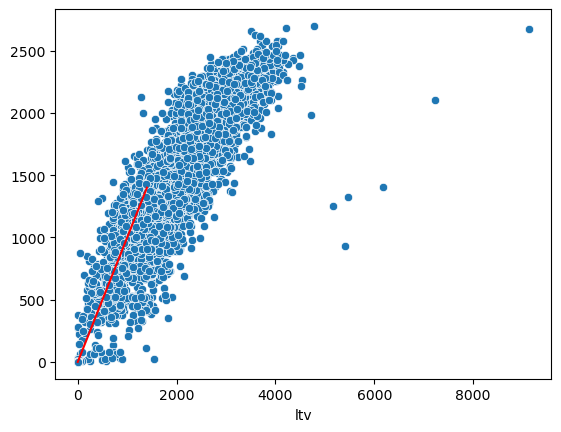

In [32]:
ax = sns.scatterplot(x=yTrain.ltv,y=np.e**reg_xgb_grid_cv.best_estimator_.predict(inX))
sns.lineplot(x=[0,1400],y=[0,1400],color='red',ax=ax)

<AxesSubplot: xlabel='ltv'>

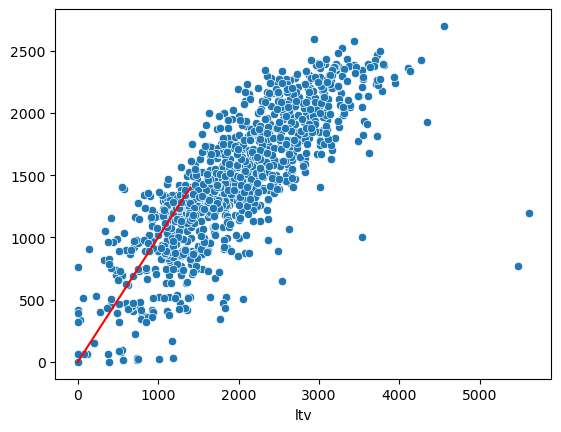

In [33]:
ax = sns.scatterplot(
    x=yTest.ltv,
    y=np.e**reg_xgb_grid_cv.best_estimator_.predict(
        xTest.join(yTest[['conversion_ind','promotion_type']])
    )
)
sns.lineplot(x=[0,1400],y=[0,1400],color='red',ax=ax)

# testing

In [22]:
bronze = pd.Series(np.ones(xTest.shape[0]),index=xTest.index).rename('promotion_type')
silver = bronze*2
gold = bronze*3

In [23]:
inX = pd.concat([xTest.join(bronze),xTest.join(silver),xTest.join(gold)])

In [24]:
convert_pred = xgb_grid_cv.best_estimator_.predict(inX)
rec_promo = inX.copy().reset_index()
rec_promo['convert'] = convert_pred

In [25]:
promo_cost = {
    0:0,
    1:500,
    2:1100,
    3:1400
}

In [26]:
pred_promo = (
    rec_promo.groupby('index')
    .apply(lambda frame: frame[frame['convert']==1]['promotion_type'].min())
    .fillna(0)
    .rename('pred_promo')
)

In [56]:
testFrame = yTest.join(pred_promo,how='left')
testFrame['promo_cost'] = testFrame['pred_promo'].map(promo_cost)

In [57]:
correct_index = testFrame[(testFrame.conversion_ind==1)&(testFrame.pred_promo>=testFrame.promotion_type)].index

In [67]:
final_revenue = testFrame.loc[correct_index].apply(lambda x: x.ltv-x.promo_cost,axis=1).sum()

In [58]:
lossRev = testFrame.loc[testFrame.index.difference(correct_index)]
lossRev = lossRev[lossRev.conversion_ind==1]

In [71]:
lossRev[lossRev.pred_promo<lossRev.promotion_type]

,promotion_type,conversion_ind,ltv,pred_promo,promo_cost
22,3,1.0,287.549652,2.0,1100
53,3,1.0,2670.217488,2.0,1100
57,2,1.0,3701.706196,1.0,500
97,3,1.0,3931.102070,2.0,1100
101,3,1.0,1884.784382,2.0,1100
...,...,...,...,...,...
9865,3,1.0,2177.622984,2.0,1100
9907,3,1.0,2959.270481,1.0,500
9940,3,1.0,1461.977998,2.0,1100
9961,3,1.0,2183.961328,1.0,500


In [59]:
lossRev[lossRev.apply(lambda x: x.promotion_type>x.pred_promo,axis=1)]

,promotion_type,conversion_ind,ltv,pred_promo,promo_cost
22,3,1.0,287.549652,2.0,1100
53,3,1.0,2670.217488,2.0,1100
57,2,1.0,3701.706196,1.0,500
97,3,1.0,3931.102070,2.0,1100
101,3,1.0,1884.784382,2.0,1100
...,...,...,...,...,...
9865,3,1.0,2177.622984,2.0,1100
9907,3,1.0,2959.270481,1.0,500
9940,3,1.0,1461.977998,2.0,1100
9961,3,1.0,2183.961328,1.0,500
